## Import

In [1]:
import pandas as pd
from config import BASE_DIR, RESULTS_DIR
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Load

In [2]:
from math import e


garch_df = pd.read_csv(f'{RESULTS_DIR}/metrics/garch_metrics.csv')
xgb_df = pd.read_csv(f'{RESULTS_DIR}/metrics/xgboost_metrics.csv')
garch_pred = pd.read_csv(f'{RESULTS_DIR}/preds/garch_preds.csv')
xgb_pred  = pd.read_csv(f'{RESULTS_DIR}/preds/xgboost_preds.csv')
egarch_df = pd.read_csv(f'{RESULTS_DIR}/metrics/egarch_metrics.csv')
egarch_pred = pd.read_csv(f'{RESULTS_DIR}/preds/egarch_preds.csv')



## Merge data and compare

In [3]:
## Merge data and compare
comparison_df = pd.concat([garch_df, xgb_df, egarch_df], ignore_index=True)
comparison_df = comparison_df.rename(columns={'R_squared': 'R²'})

# Find the best performer (highest R²)
best_model_idx = comparison_df['R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'model']

print(f" Best Model: {best_model_name} with R²: {comparison_df.loc[best_model_idx, 'R²']:.4f}")
comparison_df.to_csv(RESULTS_DIR / "metrics" / "model_comparison.csv", index=False)

 Best Model: EGARCH with R²: 0.2744


In [4]:
# Note: For R2, we want to see the increase
baseline_rmse = comparison_df.loc[0, 'rmse']
baseline_mae = comparison_df.loc[0, 'mae']
baseline_r2 = comparison_df.loc[0, 'R²']

new_rmse = comparison_df.loc[1, 'rmse']
new_mae = comparison_df.loc[1, 'mae']
new_r2 = comparison_df.loc[1, 'R²']
rmse_imp = (baseline_rmse - new_rmse) / baseline_rmse * 100
mae_imp = (baseline_mae - new_mae) / baseline_mae * 100
r2_imp = (new_r2 - baseline_r2) / baseline_r2 * 100

print(f"Efficiency Gain: XGBoost reduced RMSE by {rmse_imp:.2f}%")
print(f"Accuracy Gain: XGBoost increased R² by {r2_imp:.2f}%")

comparison_df



Efficiency Gain: XGBoost reduced RMSE by 7.29%
Accuracy Gain: XGBoost increased R² by 102.67%


,model,rmse,mae,R²
0,GARCH,0.108008,0.062021,0.115825
1,XGBoost,0.100136,0.056176,0.234745
2,EGARCH,0.097842,0.057165,0.274434


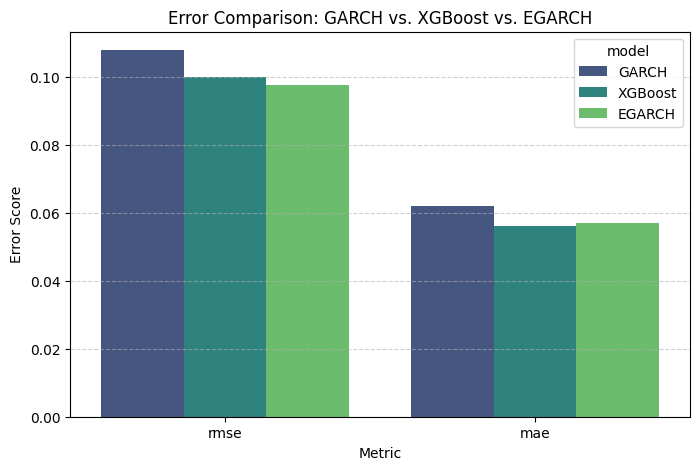

In [5]:
# Melt the dataframe for plotting
plot_data = comparison_df.melt(id_vars='model', value_vars=['rmse', 'mae'], 
                                var_name='Metric', value_name='Score')

import seaborn as sns
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_data, x='Metric', y='Score', hue='model', palette='viridis')

plt.title("Error Comparison: GARCH vs. XGBoost vs. EGARCH")
plt.ylabel("Error Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig(BASE_DIR / "assets" / "error_comparison.png")

In [7]:
df_final = pd.DataFrame(index=garch_pred.index)

df_final["Actual"] = garch_pred["target_vol"]
df_final["GARCH"] = garch_pred["garch_pred"]
df_final["XGBoost"] = xgb_pred["xgboost_forecast"]
df_final["EGARCH"] = egarch_pred["egarch_forecast"]


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_final.index, 
    y=df_final["Actual"],
    name="Actual Volatility",
    line=dict(color='#0077B6', width=2),
    opacity=0.5
))

fig.add_trace(go.Scatter(
    x=df_final.index, 
    y=df_final["GARCH"],
    name="GARCH",
    line=dict(color='#FB8500', width=1.5)
))

fig.add_trace(go.Scatter(
    x=df_final.index, 
    y=df_final["XGBoost"],
    name="XGBoost",
    line=dict(color='#8E24AA', width=1.5)
))


fig.add_trace(go.Scatter(
    x=df_final.index, 
    y=df_final["EGARCH"],
    name="EGARCH",
    line=dict(color='#2A9D8F', width=2)
))


forecast_start_idx = len(df_final) - 21
forecast_start_date = df_final.index[forecast_start_idx]

fig.add_vline(
    x=forecast_start_date, 
    line_dash="dash", 
    line_color="red",
    annotation_text="2026 Forecast Start",
    annotation_position="top left"
)


fig.update_layout(
    title="Master Comparison: Historical Accuracy vs. Jan 2026 Forecast",
    xaxis_title="Date / Step",
    yaxis_title="Volatility",
    hovermode="x unified",  
    template="plotly_white",
    legend=dict(
        title="Toggle Models:",
        orientation="v",
        yanchor="top", y=1,
        xanchor="left", x=1.02
    )
)

fig.show()


fig.write_html(RESULTS_DIR / "preds" / "model_comparison.html")